# Credit Card Fraud Detection

***By Joe Corliss***

[Data source on Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

[Notebook on Kaggle](https://www.kaggle.com/pileatedperch/linear-svc-random-forest-mcc-0-77-0-88)

[GitHub Repository](https://github.com/jgcorliss/credit-card-fraud)

## Table of Contents

1. [Check the Data](#1)
2. [Pre-processing](#2)
3. [Predictive Modeling](#3)
    1. [Linear Classification with Stochastic Gradient Descent (SGD)](#3.1)
    2. [Random Forest Classifier](#3.2)

# Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

# Basic Metadata
<a id='1'></a>

Read in the data to a pandas dataframe.

In [2]:
df = pd.read_csv('creditcard.csv')

Check basic metadata.

In [3]:
df.shape

(284807, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Are there any incomplete variables?

In [5]:
def incomplete_cols(df):
    """
    Returns a list of incomplete columns in df and their completion percentage.
    
    Input: pandas DataFrame
    """
    cmp = df.notnull().mean()
    cmp = cmp.loc[cmp<1]
    dec = np.int64(np.ceil(np.log10(df.shape[0]))) - 2 # Number of decimal places based on no. of samples
    return cmp.apply(lambda val: str(np.round(100*val, decimals=dec))+'%')

In [6]:
incomplete_cols(df)

Series([], dtype: float64)

All variables have complete data!

Let's randomly sample some observations (credit card transactions).

In [7]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
21138,31493.0,1.041042,-0.316562,2.199815,3.076336,-1.510134,0.968672,-1.345969,0.547037,1.403203,0.284928,-1.980966,-0.381965,-1.689846,-0.969600,-1.725340,0.202856,0.156762,0.129807,-0.514744,-0.272248,0.042675,0.521408,-0.104770,0.353661,0.423715,0.258505,0.083026,0.036427,7.41,0
179642,124173.0,-0.360346,-0.271152,1.855506,-2.312273,-0.836129,-0.464827,-0.268658,-0.117100,-2.371896,0.661697,-0.915532,-0.760479,1.282668,-0.795489,-0.099871,-0.787100,0.634848,0.024811,0.221953,-0.170799,-0.123351,0.127745,-0.356046,0.002250,0.470134,0.030304,0.076214,0.062067,8.00,0
62275,50207.0,1.256623,-0.551237,0.124840,-0.502296,-0.939126,-0.683879,-0.690051,0.009728,-0.569066,0.137367,0.128067,-1.273838,-0.925992,-1.075962,1.361414,1.380893,1.368633,-1.151294,-0.054491,0.103002,0.090294,0.059957,0.001236,-0.027900,0.236877,-0.254399,0.029524,0.048126,57.40,0
153655,99758.0,2.048422,-0.083175,-1.026866,0.045418,0.325310,-0.055775,-0.277954,-0.060384,1.611372,-0.123673,1.531807,-1.782662,1.695552,1.935968,-0.485742,0.815158,-0.339441,0.216192,0.355904,-0.171217,-0.601726,-1.595282,0.504229,-0.025202,-0.678148,-0.032650,-0.106207,-0.062882,12.08,0
151958,96566.0,2.066953,-0.163657,-1.143930,0.367885,0.098248,-0.515322,-0.129773,-0.269238,2.429966,-0.575858,-0.237365,-2.058268,1.551673,1.464800,-1.123553,-0.620691,0.620387,-0.093210,0.126274,-0.254333,-0.084030,0.297006,0.066634,0.662440,0.211121,0.126952,-0.058325,-0.062764,6.03,0


How balanced are the classes, i.e. how common are fraudulent transactions?

In [18]:
def perc_value_counts(series):
    """
    Returns normalized value counts as percentages, including NA values, sorted by the index.
    
    Input: pandas Series
    """
    dec = np.int64(np.ceil(np.log10(len(series)))) - 2 # Number of decimal places based on no. of samples
    percs = series.value_counts(normalize=True, dropna=False).apply(lambda val: str(np.round(100*val, decimals=dec))+'%')
    return percs.sort_index()

In [19]:
perc_value_counts(df['Class'])

TypeError: 'NoneType' object is not subscriptable

Only 0.17% of transactions are fraudulent.

# Train/Test Split

Before we begin preprocessing, we split off a test data set.

Split the data into features and response variable:

In [10]:
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class'] # Response variable
df = None # Delete original dataframe to save memory

Do an 80/20 train/test split. We also stratify the split on the response variable, which is very important to do because there are so few fraudulent transactions.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
random_state = 1 # Just to make the results deterministic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [13]:
# Prevent view warnings
X_train.is_copy = False
X_test.is_copy = False

# Exploratory Data Analysis

We conduct EDA only on the training set, and leave the test set unknown.

## Time

Look at summary statistics:

In [20]:
X_train['Time'].describe()

count    227845.000000
mean      94707.617670
std       47523.204111
min           0.000000
25%       54086.000000
50%       84609.000000
75%      139261.000000
max      172792.000000
Name: Time, dtype: float64

What time is the last transaction, in numbers of days after the first transaction?

In [15]:
X_train['Time'].max()/(3600*24)

1.9999074074074075

So the transactions indeed occur over a two-day period.

Histogram of transaction times:

Text(0.5,1,'Transaction Times')

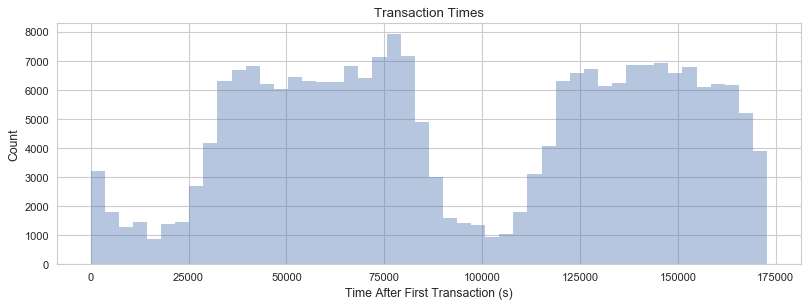

In [21]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Time'], bins=48, kde=False)
plt.xlabel('Time After First Transaction (s)')
plt.ylabel('Count')
plt.title('Transaction Times')

It looks like there are two lulls in credit card transactions during nighttime on each day.

## Amount

In [22]:
X_train['Amount'].describe()

count    227845.000000
mean         88.709296
std         250.026305
min           0.000000
25%           5.550000
50%          22.000000
75%          77.890000
max       25691.160000
Name: Amount, dtype: float64

Compare the median and the maximum---it looks like the amounts are very right-skewed. We'll verify this, starting with a histogram of the transaction amounts:

Text(0.5,1,'Transaction Amounts')

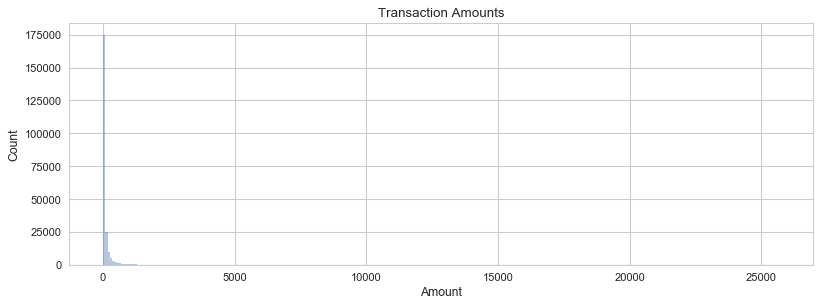

In [24]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Amount'], bins=300, kde=False)
plt.ylabel('Count')
plt.title('Transaction Amounts')

The histogram is hard to read due to some outliers we can't see. A boxplot will show the outliers:

Text(0.5,1,'Transaction Amounts')

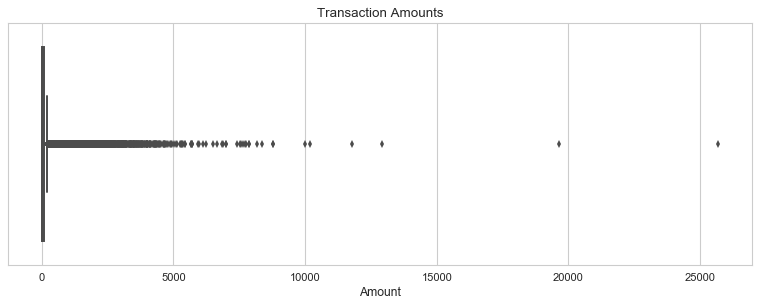

In [25]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['Amount'])
plt.title('Transaction Amounts')

We can see there are no outliers on the left and many outliers on the right. So the amounts certainly seem right-skewed. We can calculate the skewness to be sure:

In [26]:
X_train['Amount'].skew()

16.910303546516744

That's a strong right skew. Let's use a power transform to bring the transaction amounts closer to a normal distribution. We'll use the [Box-Cox transform in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html), but some of the amounts are zero (min = 0 above), so we need to shift the amounts first to make them positive. We'll shift by a very small amount, just $10^{-9}$.

In [27]:
X_train.loc[:,'Amount'] = X_train['Amount'] + 1e-9 # Shift all amounts by 1e-9

Box-Cox transform:

In [28]:
X_train.loc[:,'Amount'], maxlog, (min_ci, max_ci) = sp.stats.boxcox(X_train['Amount'], alpha=0.01)

The maximum likelihood estimate of $\lambda$ in the Box-Cox transform:

In [29]:
maxlog

0.13436569191158662

The 99% confidence interval for $\lambda$:

In [30]:
(min_ci, max_ci)

(0.13291390124729957, 0.1358266545085391)

Plot the newly transformed amounts:

Text(0.5,1,'Transaction Amounts (Box-Cox Transformed)')

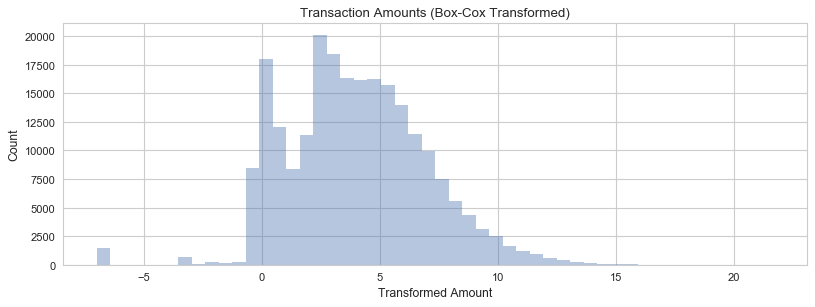

In [33]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Amount'], kde=False)
plt.xlabel('Transformed Amount')
plt.ylabel('Count')
plt.title('Transaction Amounts (Box-Cox Transformed)')

New descriptive stats:

In [34]:
X_train['Amount'].describe()

count    227845.000000
mean          3.985515
std           2.972505
min          -6.982733
25%           1.927181
50%           3.831861
75%           5.919328
max          21.680566
Name: Amount, dtype: float64

Much nicer! We'll fully standardize the data later (transform to zero mean and unit variance). But now we need to perform Box-Cox on the test data amounts as well, using the $\lambda$ value estimated on the training data.

In [35]:
X_test.loc[:,'Amount'] = X_test['Amount'] + 1e-9 # Shift all amounts by 1e-9

In [36]:
X_test.loc[:,'Amount'] = sp.stats.boxcox(X_test['Amount'], lmbda=maxlog)

## V1-V28

Let's compare the descriptive stats of the PCA variables `V1-V28`.

In [38]:
pca_vars = ['V%i' % k for k in range(1,29)]

Table of descriptive stats:

In [39]:
X_train[pca_vars].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,-0.000713,-0.001034,0.002557,0.003839,-0.002857,0.002085,0.000022,0.000093,0.000243,-0.000363,0.000651,-0.000834,-0.000976,0.002291,-0.000595,-0.000499,0.000587,0.001448,-0.000146,-0.000796,0.000023,0.000897,0.000765,-0.000380,0.000136,-0.000301,-0.000046,-0.000027
std,1.952399,1.636689,1.514288,1.417086,1.383532,1.333769,1.240239,1.200348,1.096453,1.082580,1.020932,1.000266,0.996678,0.957485,0.916946,0.876978,0.846748,0.838169,0.815140,0.767956,0.733325,0.725353,0.616772,0.605741,0.522184,0.482187,0.405182,0.331048
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.431131,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.335193,-7.213527,-54.497720,-34.830382,-10.933144,-36.666000,-2.836627,-8.696627,-2.534330,-22.565679,-15.430084
25%,-0.922830,-0.599928,-0.887861,-0.844052,-0.693702,-0.766195,-0.555377,-0.208302,-0.642006,-0.535079,-0.761255,-0.406597,-0.650225,-0.423563,-0.584357,-0.469513,-0.484153,-0.497660,-0.456946,-0.212129,-0.227952,-0.541079,-0.162242,-0.354208,-0.317488,-0.327576,-0.070767,-0.053013
50%,0.016743,0.064370,0.180865,-0.016750,-0.055388,-0.271706,0.039185,0.022594,-0.051224,-0.091877,-0.032213,0.141227,-0.014920,0.051939,0.047181,0.066080,-0.065260,-0.001867,0.004371,-0.062809,-0.029095,0.007661,-0.011184,0.040977,0.017081,-0.052599,0.001373,0.011255
75%,1.315147,0.801738,1.027592,0.746907,0.611056,0.401204,0.569307,0.328079,0.596563,0.455577,0.740921,0.617925,0.663521,0.495181,0.649788,0.522836,0.400067,0.501554,0.459695,0.132873,0.186678,0.529342,0.147825,0.438432,0.351400,0.240554,0.091028,0.078341
max,2.451888,22.057729,9.382558,16.715537,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.207059,5.041069,5.591971,39.420904,27.202839,10.503090,22.083545,4.584549,7.519589,3.517346,31.612198,33.847808


It's tiresome to interpret this summary statistics table, so let's make some visualizations. Start by plotting the means:

Text(0.5,1,'V1-V28 Means')

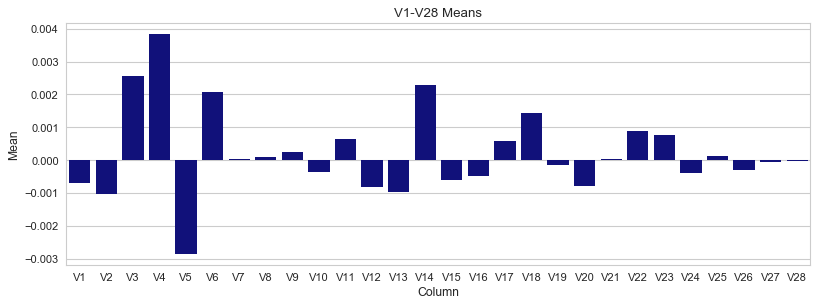

In [40]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].mean(), color='darkblue')
plt.xlabel('Column')
plt.ylabel('Mean')
plt.title('V1-V28 Means')

All of `V1-V28` have approximately zero mean.

Plot the standard deviations:

Text(0.5,1,'V1-V28 Standard Deviations')

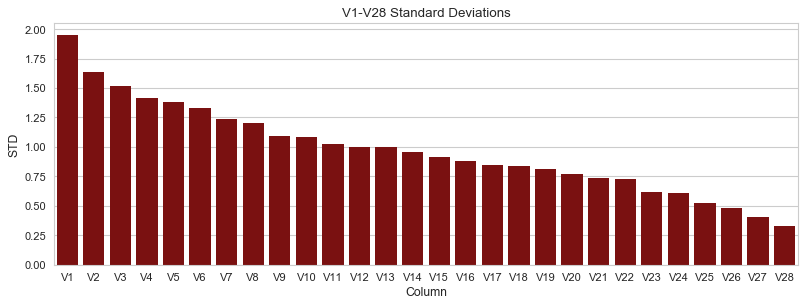

In [53]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].std(), color='darkred')
plt.xlabel('Column')
plt.ylabel('STD')
plt.title('V1-V28 Standard Deviations')

The PCA variables have roughly unit variance, but as low as ~0.3 and as high as ~1.9.

Plot the skewnesses:

Text(0.5,1,'V1-V28 Skewnesses')

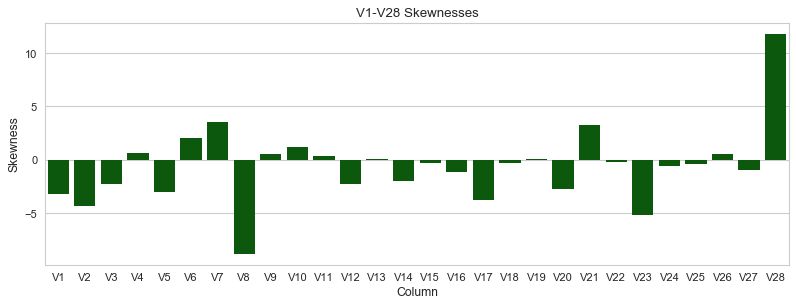

In [54]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].skew(), color='darkgreen')
plt.xlabel('Column')
plt.ylabel('Skewness')
plt.title('V1-V28 Skewnesses')

A few of the PCA variables are significantly skewed. Let's plot one of the particularly skewed variables to see the distribution in detail.

Text(0.5,1,'V8')

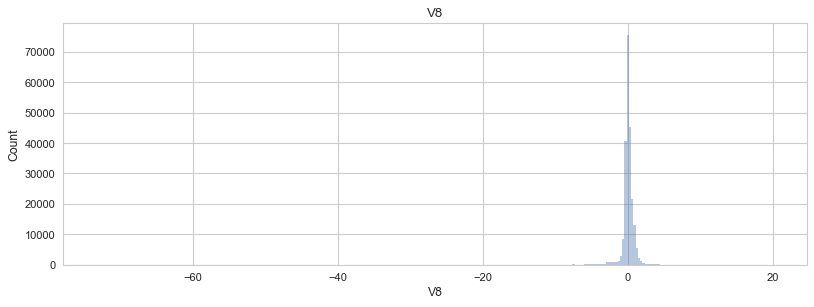

In [43]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['V8'], bins=300, kde=False)
plt.ylabel('Count')
plt.title('V8')

The histogram doesn't show us outliers. Let's try a boxplot instead:

Text(0.5,1,'V8')

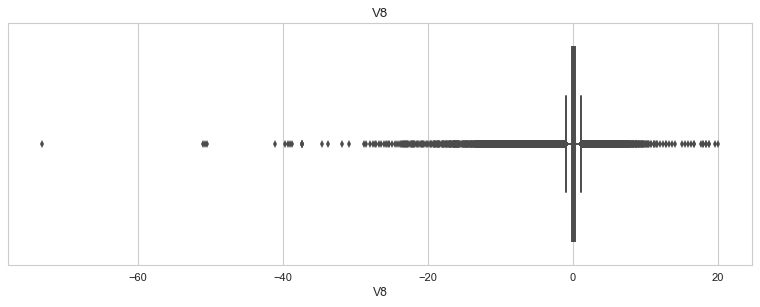

In [44]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['V8'])
plt.title('V8')

The boxplot is also hard to read due to the large number of outliers, which indicates high kurtosis in `V8`. This motivates us to plot the kurtoses of the PCA variables. The kurtosis method employed in pandas is Fisher’s definition, for which the standard normal distribution has kurtosis 0.

Note the log scale in the plot below:

Text(0.5,1,'V1-V28 Kurtoses')

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


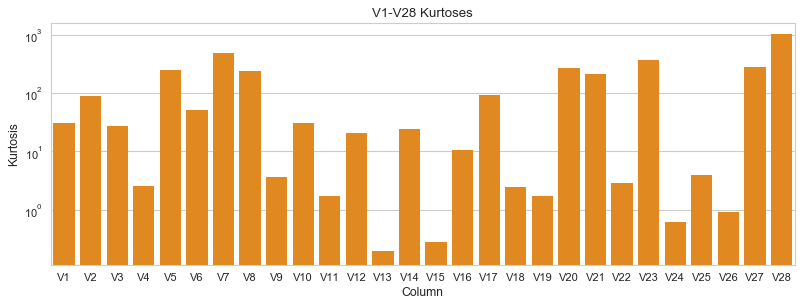

In [62]:
plt.figure(figsize=(12,4), dpi=80)
plt.yscale('log')
sns.barplot(x=pca_vars, y=X_train[pca_vars].kurtosis(), color='darkorange')
plt.xlabel('Column')
plt.ylabel('Kurtosis')
plt.title('V1-V28 Kurtoses')

We've learned that many of the PCA variables are *very* heavily tailed.

A variable of particular interest is `V28`, which has both the highest skewness and the highest kurtosis among the PCA variables. Let's take a closer look, starting with a histogram:

Text(0.5,1,'V28')

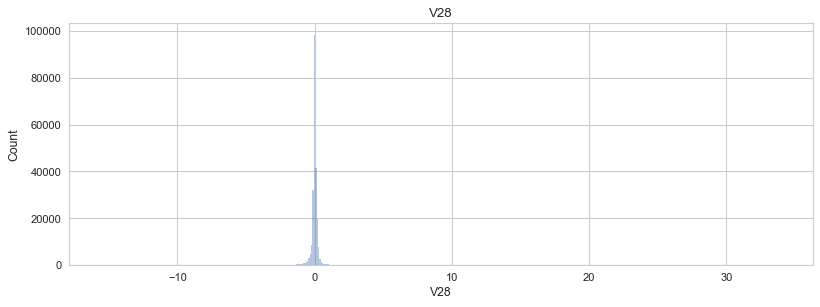

In [64]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['V28'], bins=500, kde=False)
plt.ylabel('Count')
plt.title('V28')

And a boxplot:

Text(0.5,1,'V28')

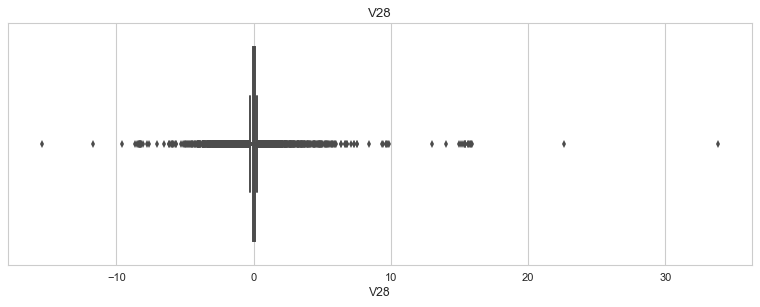

In [48]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['V28'])
plt.title('V28')

We see a large number of outliers, as suggested by the very high kurtosis:

In [50]:
X_train['V28'].kurtosis()

1028.0950513745493

Because `V28` is the last PCA variable, it should be the "least important," i.e. it accounts for the least variance in the original data as compared to `V1-V27`. So hopefully the high skewness/kurtosis in `V28` will not cause much difficulty in modeling. As for `V1-V27`, it's harder to say.

The large numbers of outliers in `V1-V28` motivates us to consider more robust descriptive statistics. Let's plot the medians:

Text(0.5,1,'V1-V28 Medians')

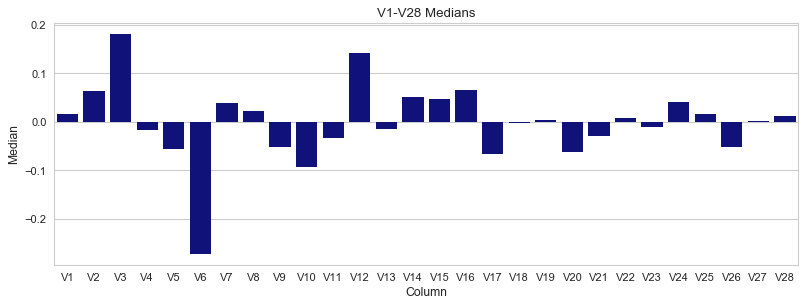

In [51]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].median(), color='darkblue')
plt.xlabel('Column')
plt.ylabel('Median')
plt.title('V1-V28 Medians')

The medians are also roughly zero. Next we look at the interquartile range (IQR)*:

*Pandas does not have a built-in IQR method, so we use a percentile calculator.

Text(0.5,1,'V1-V28 IQRs')

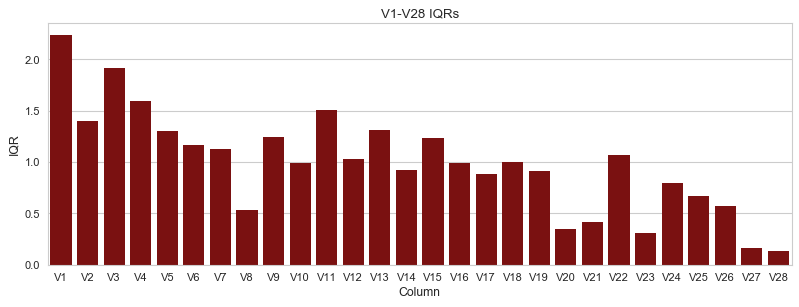

In [56]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].quantile(0.75) - X_train[pca_vars].quantile(0.25), color='darkred')
plt.xlabel('Column')
plt.ylabel('IQR')
plt.title('V1-V28 IQRs')

The IQRs of `V1-V28` are on a similar scale as the standard deviations.

# Data Standardization

Because the STD and IQR of `V1-V28` are similar in size, it should work fine to standardize the data to zero mean and unit variance.

In [65]:
from sklearn.preprocessing import StandardScaler

Fit the scaler only to the training data to avoid test set leakage.

In [66]:
scaler = StandardScaler().fit(X_train)

Scale the data.

In [67]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# Predictive Modeling
<a id='3'></a>

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Linear Classification with Stochastic Gradient Descent (SGD)
<a id='3.1'></a>

In [69]:
from sklearn.linear_model import SGDClassifier

The estimator [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) implements multiple linear classifiers with SGD training, which makes learning much faster on large datasets at the cost of accuracy.

### Train with grid search

The linear classifier is chosen with the `loss` hyperparameter. We'll try a linear SVC (`loss = 'hinge'`) and logistic regression (`loss = 'log'`).

Set the hyperparameter grid:

In [110]:
param_grid = [{'loss': ['hinge'],
               'alpha': [10**k for k in range(-3,4)],
               'class_weight': [None, 'balanced']
              },
              {'loss': ['log'],
               'penalty': ['l1', 'l2'],
               'alpha': [10**k for k in range(-3,3)]
              }]

The grid search will employ [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) with 3 folds for the train/CV splits, by default for [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). We'll use the [Matthews correlation coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) (MCC) as our scoring metric.

In [111]:
sgdcls_grid = GridSearchCV(estimator=SGDClassifier(max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=0)

Perform the grid search:

In [77]:
sgdcls_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=0.001, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'loss': ['hinge'], 'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [None, 'balanced']}, {'loss': ['log'], 'penalty': ['l1', 'l2'], 'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(matthews_corrcoef), verbose=0)

What are the optimal parameters found in our grid search?

In [78]:
sgdcls_grid.best_params_

{'alpha': 10, 'class_weight': 'balanced', 'loss': 'hinge'}

Mean cross-validated score of the best estimator:

In [80]:
sgdcls_grid.best_score_

0.8064212124173448

### Test set evaluation

Make test set predictions.

In [112]:
y_pred_sgdcls = sgdcls_grid.predict(X_test)

Calculate evaluation metrics.

In [91]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, accuracy_score

In [113]:
# Display classification evaluation metrics
def classification_eval(y_test, y_pred):
    dec = np.int64(np.ceil(np.log10(len(y_test)))) # Number of decimal places based on no. of samples
    print('Confusion matrix')
    print(confusion_matrix(y_test, y_pred), '\n')
    print('Classification report')
    print(classification_report(y_test, y_pred, digits=dec))
    print('Scalar metrics')
    format_str = '%%8s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

In [114]:
classification_eval(y_test, y_pred_sgdcls)

Confusion matrix
[[56839    25]
 [   12    86]] 

Classification report
             precision    recall  f1-score   support

          0    0.99979   0.99956   0.99967     56864
          1    0.77477   0.87755   0.82297        98

avg / total    0.99940   0.99935   0.99937     56962

Scalar metrics
     MCC = 0.82424
Accuracy = 0.99935


## Random Forest Classifier
<a id='3.2'></a>

In [102]:
from sklearn.ensemble import RandomForestClassifier

### Train

The random forest takes much longer to train on this fairly large dataset, so we won't tune the hyperparameters with a grid search. We'll just use default values, except for using 100 estimators (the default is 10) and building trees in parallel (`n_jobs = -1`).

In [103]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)

In [104]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### Test set evaluation

Make test set predictions.

In [115]:
y_pred_rf = rf.predict(X_test)

Calculate evaluation metrics.

In [116]:
classification_eval(y_test, y_pred_rf)

Confusion matrix
[[56858     6]
 [   15    83]] 

Classification report
             precision    recall  f1-score   support

          0    0.99974   0.99989   0.99982     56864
          1    0.93258   0.84694   0.88770        98

avg / total    0.99962   0.99963   0.99962     56962

Scalar metrics
     MCC = 0.88855
Accuracy = 0.99963


The random forest performed better than the linear SVC, according to the MCC. However, the results may vary for different train/test splits.

### Feature Importances

We can examine the random forest's estimated feature importances: the higher, the more important the feature. The feature importances always add up to 1.

Text(0.5,1,'Random Forest Feature Importances')

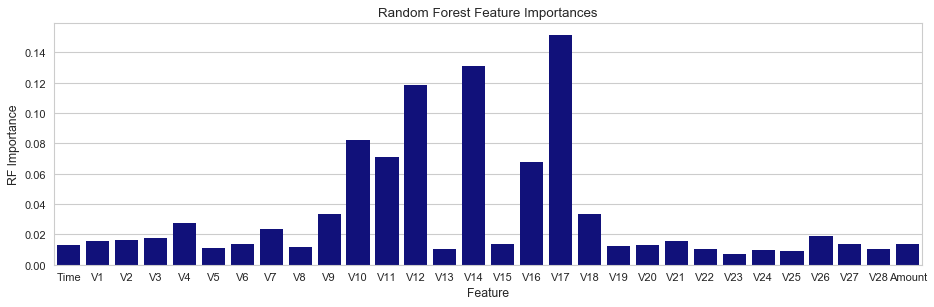

In [120]:
plt.figure(figsize=(14,4), dpi=80)
sns.barplot(x=X.columns, y=rf.feature_importances_, color='darkblue')
plt.xlabel('Feature')
plt.ylabel('RF Importance')
plt.title('Random Forest Feature Importances')

It appears that only six or so features---`V10`, `V11`, `V12`, `V14`, `V16`, `V17`---are important in detecting fraud. Unfortunately, because these variables came out of PCA, we cannot interpret their meaning.